In [1]:
# Imports of necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# import the CMU movie datasets
movie_column_names = ['Wikipedia_movie_ID',
                'Freebase_movie_ID',
                'movie_name',
                'movie_release_date',
                'movie_box_office_revenu',
                'movie_runtime',
                'movie_languages',
                'movie_countries',
                'movie_genres']

folder_path = os.path.abspath('MovieSummaries')

df_movies = pd.read_csv(os.path.join(folder_path, "movie.metadata.tsv"), delimiter='\t', names = movie_column_names)
df_summaries = pd.read_csv(os.path.join(folder_path, "plot_summaries.txt"), delimiter='\t', names=['Wikipedia_movie_ID', 'movie_summary'])

# 0) Get Dataset and subset

### Convert the genres objects into dictionnaries

In [18]:
# Convert the genres objects into dictionnaries
genres_list = df_movies['movie_genres'].apply(lambda x: eval(x) if pd.notna(x) else {})

# Initialize an empty list to store the new relations <movie, genre>
new_rows = []

# Iterate over each row and process the genre dictionaries into new rows related to the movie's ID
for i, genres_dict in enumerate(genres_list):
    movie_id = df_movies.loc[i, 'Wikipedia_movie_ID']

    for genre_id, genre_name in genres_dict.items():
        new_rows.append({'Wikipedia_movie_ID': movie_id, 'Freebase_genre_ID': genre_id, 'movie_genre': genre_name})

# Create a new DataFrame from the list of rows and save it as csv
df_genres = pd.DataFrame(new_rows)
df_genres.to_csv('cleaned_genres.csv', index=False)
print(df_genres.head())

   Wikipedia_movie_ID Freebase_genre_ID      movie_genre
0              975900         /m/01jfsb         Thriller
1              975900          /m/06n90  Science Fiction
2              975900          /m/03npn           Horror
3              975900         /m/03k9fj        Adventure
4              975900          /m/0fdjb     Supernatural


In [20]:
df_summaries = df_summaries.rename(columns = {'Wikipedia_movie_ID' : 'movie_ID'})

### Fictional movie subset

In [21]:
df_fictional = df_genres[df_genres['movie_genre'].isin(['Science Fiction', 'Fantasy'])].copy()
print(f"The total number of movies referred to as fictional is {df_fictional['Wikipedia_movie_ID'].unique().size}, corresponding to {df_fictional['Wikipedia_movie_ID'].unique().size/df_movies['Wikipedia_movie_ID'].unique().size:.2%} of whole movies.")

The total number of movies referred to as fictional is 5366, corresponding to 6.56% of whole movies.


In [22]:
# Get 2 subset of movies ID based on genre clearly fictional and non fictional
fictional_wiki_movie_id = df_fictional['Wikipedia_movie_ID'].unique().copy() #defined in Part 1 ('Science Fiction' and 'Fantasy')
non_fictional_wiki_movie_id = df_genres[df_genres['movie_genre'].isin(['Documentary', 'Biography', 'Culture & Society', 'Biographical film', 'Biopic [feature]', 'History'])]['Wikipedia_movie_ID'].unique().copy()

print(f"The total number of movies IDs in each subset for fictional is {fictional_wiki_movie_id.size} and for non-fictional is {non_fictional_wiki_movie_id.size}.")

The total number of movies IDs in each subset for fictional is 5366 and for non-fictional is 7778.


In [23]:
# Now we find the summaries associated to each movies. (Note: not all movies have a summary !)
fictional_summaries = df_summaries[df_summaries['movie_ID'].isin(fictional_wiki_movie_id)]['movie_summary']
non_fictional_summaries = df_summaries[df_summaries['movie_ID'].isin(non_fictional_wiki_movie_id)]['movie_summary']

print(f"The total number of summaries in each subset for fictional is {fictional_summaries.size} and for non-fictional is {non_fictional_summaries.size}.")
print(f'The percents of fictional and non-fictional summaries are: {fictional_summaries.size/ (fictional_summaries.size + non_fictional_summaries.size):.1%} vs {non_fictional_summaries.size/ (fictional_summaries.size + non_fictional_summaries.size):.1%}')

The total number of summaries in each subset for fictional is 3941 and for non-fictional is 2382.
The percents of fictional and non-fictional summaries are: 62.3% vs 37.7%


# 1) LDA performing

In [150]:
# import further necessary packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import spacy

In [77]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [149]:
# Data sample as the previously defined subset of fictional summaries
sample_summaries = fictional_summaries.copy()

# Text preprocessing to remove Proper nouns (NPP)
def filter_names(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    filtered_tokens = [token for token, pos in tagged_tokens if pos != 'NNP']
    return ' '.join(filtered_tokens)


# Preprocess the documents
preprocessed_sample_summaries = [filter_names(doc) for doc in sample_summaries['movie_summary']]
preprocessed_sample_summaries

["The nation of consists of a wealthy and twelve poorer districts . As punishment for a past rebellion , each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Games . The tributes must fight to the death in an arena ; the sole survivor is rewarded with fame and wealth . In her first , 12-year-old is chosen from 12 . Her older sister volunteers to take her place . , a baker 's son who once gave bread when she was starving , is the other 12 tribute . and are taken to the , accompanied by their frequently drunk mentor , past victor . He warns them about the `` '' tributes who train intensively at special academies and almost always win . During a TV interview with , unexpectedly reveals his love for . She is outraged , believing it to be a ploy to gain audience support , as `` sponsors '' may provide in-Games gifts of food , medicine , and tools . However , she discovers meant what he said . The televised begin with half of the tributes

In [151]:
len(preprocessed_sample_summaries)

3941

In [107]:
text = 'her name is emily.'
tokens = word_tokenize(text)
tagged_tokens = pos_tag(tokens)
print(tagged_tokens)
filtered_tokens = [token for token, pos in tagged_tokens if pos != 'NNP']

[('her', 'PRP$'), ('name', 'NN'), ('is', 'VBZ'), ('emily', 'RB'), ('.', '.')]


In [115]:
# Custom tokenizer function to exclude proper nouns
def custom_tokenizer(text):
    tokens = []
    doc = nlp(text)
    for token in doc:
        if token.pos_ not in ["PROPN", "NOUN"] and not token.is_stop:  # Exclude proper nouns and stop words
            tokens.append(token.lemma_)
    return tokens


In [133]:
# General parameters to adapt
n_features = 2000
n_components = 10
n_top_words = 10

# Vectorize the summaries
vectorizer = CountVectorizer(max_df=0.50, min_df=5, max_features=n_features, stop_words="english")

#dtm = vectorizer.fit_transform(preprocessed_sample_summaries)

#vectorizer = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=10, max_features=n_features)
dtm = vectorizer.fit_transform(preprocessed_sample_summaries)

# Create the LatentDirichletAllocation model
lda = LatentDirichletAllocation(
    n_components=n_components,
    learning_method = 'online',
    max_iter=15,
    random_state=7,
)

lda.fit(dtm)

# Define function to show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

# Show the topics with their n_top words in a DataFrame form
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda, n_words=n_top_words)
df_topic_keywords = pd.DataFrame(topic_keywords)

# Improve comprehension with adapted column and index names
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
display(df_topic_keywords)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,alien,planet,space,aliens,earth,ship,mission,nuclear,station,destroy
Topic 1,creature,monster,group,creatures,island,cave,giant,water,animals,spider
Topic 2,family,father,man,young,mother,wife,son,life,old,woman
Topic 3,castle,fight,battle,kill,father,king,tells,village,dragon,men
Topic 4,tells,finds,room,night,away,house,goes,tries,home,car
Topic 5,kill,killed,kills,body,killing,human,group,government,blood,infected
Topic 6,ship,crew,robot,escape,attack,killed,helicopter,team,island,city
Topic 7,time,film,world,life,new,machine,love,story,human,future
Topic 8,police,gang,body,time,killed,escape,death,murder,prison,factory
Topic 9,school,children,help,home,father,game,friends,parents,make,tells


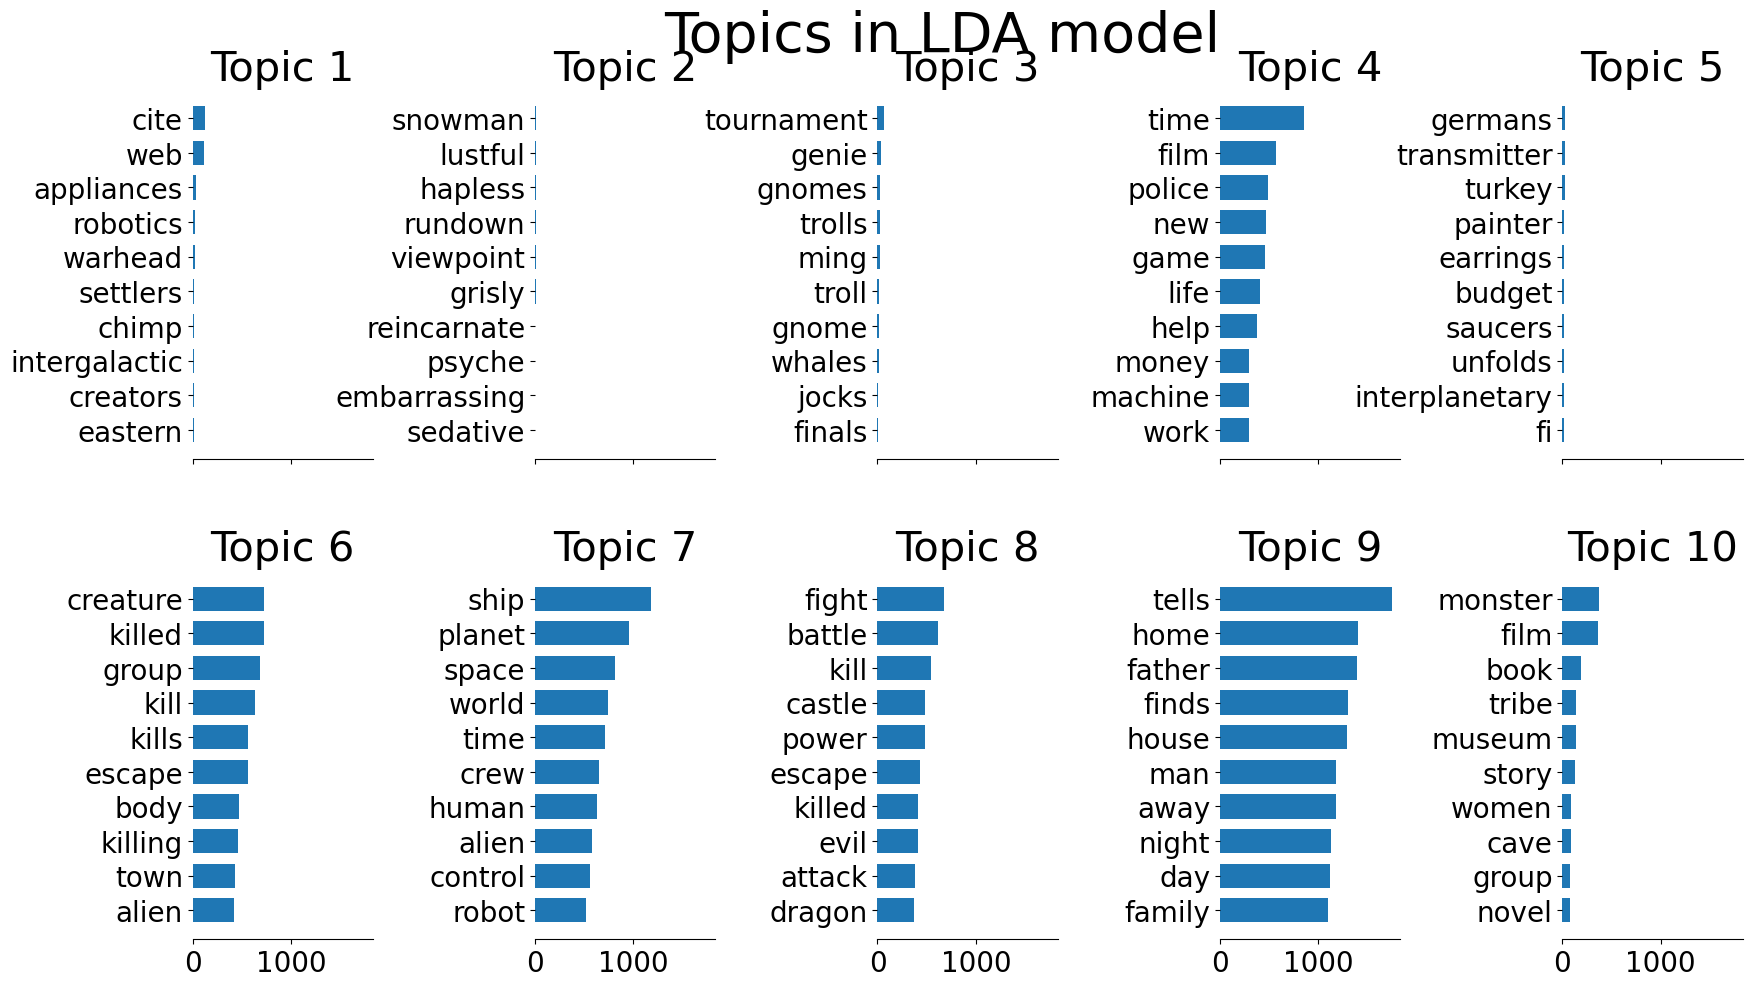

In [132]:
def plot_top_words(model, feature_names, n_top_words, n_topics, title):
    """
    Function to plot n top words for m topics as horizontals barplots with the measured weight.
    
    This function is taken and adapted from sklearn example at https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
    """
    # Get number of rows and columns to plot
    row_n = np.ceil(n_topics/5).astype(int)
    col_n = min([n_topics, 5])
    
    # Main figure with row_n x col_n subplots 
    fig, axes = plt.subplots(row_n, col_n, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        # getting words and their weight from topics
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        # plot results as horizontal bars
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Plot the top n words for all topics
tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, n_topics=n_components, title="Topics in LDA model")

## Find topic related to movie

In [ ]:
fictional_summaries = sample_summaries.copy().reset_index()

In [49]:
topic_names = ['familiy', 'crime', 'worlwide_war', 'robot_science', 'time_travel', 'space', 'monster', 'creatures', 'vampires', 'fight_kings']

In [55]:
i = fictional_summaries.sample(1)

print(i['movie_summary'].values)
topic_distrib = lda.transform(dtm[i.index,:])
print(topic_distrib)
print(topic_names[topic_distrib.argmax()])

['Branded as a "nerd" and harassed by the school bully, twelve-year-old Arthur is rescued by a magical troll who knows that the boy unwittingly holds the secret to defeat an evil dragon. Arthur\'s loving mom, struggling to keep her devious ex-husband from gaining custody of Arthur, dismisses her son’s "fantasies" until she realizes the all too real immediate danger and joins forces with Arthur, the troll, and a dashing but washed up video-game master. Together, they hope to conquer the dragon and the wicked vice-principal who threaten civilization.']
[[0.41326681 0.00400058 0.00400092 0.0040011  0.00400054 0.00400166
  0.1229096  0.00400125 0.43581648 0.00400106]] vampires


In [62]:
vectorizer.inverse_transform(dtm[i.index,:])

[array(['boy', 'year', 'old', 'son', 'evil', 'defeat', 'game', 'ex',
        'knows', 'realizes', 'husband', 'secret', 'magical', 'real',
        'forces', 'dragon', 'holds', 'school', 'joins', 'master', 'video',
        'hope', 'rescued'], dtype='<U13')]

# Try with gensim

In [144]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
# spaCy for preprocessing
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [135]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["'s"])

In [154]:
sample_summaries

,index,movie_summary
0,1,The nation of Panem consists of a wealthy Capi...
1,49,"The evil Lord Conqueror, head of Conqueror's C..."
2,54,During the Great depression in 1933 in Winnipe...
3,76,"In Los Angeles, California Fletcher Reede is ..."
4,80,"In the winter of 1945, immediately after the l..."
...,...,...
3936,42259,The following is a detailed overview of the mi...
3937,42264,"In the not too distant future, society has lev..."
3938,42276,"In the 13th century, three women accused of wi..."
3939,42292,While drinking alone one night and reminiscing...


In [187]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Tokenize documents using spaCy
tokenized_docs = []

for doc in nlp.pipe(sample_summaries['movie_summary'], batch_size=100, n_process=4):
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.pos_ not in ['PROPN']]
    tokenized_docs.append(tokens)


In [188]:
# Create a Gensim dictionary
dictionary = Dictionary(tokenized_docs)

# Filter out extreme cases (optional)
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

In [189]:
# Create a Gensim corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [190]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 8339
Number of chunks: 3941


In [191]:
# models
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': 7}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [192]:
model.show_topics(num_words=5)

[(0,
  '0.006*"human" + 0.006*"take" + 0.006*"world" + 0.005*"man" + 0.005*"kill"'),
 (1,
  '0.013*"creature" + 0.010*"kill" + 0.007*"attack" + 0.007*"ship" + 0.006*"leave"'),
 (2,
  '0.008*"destroy" + 0.007*"kill" + 0.007*"time" + 0.006*"ship" + 0.006*"power"'),
 (3,
  '0.015*"kill" + 0.009*"dragon" + 0.007*"time" + 0.006*"leave" + 0.006*"tell"'),
 (4,
  '0.021*"kill" + 0.010*"monster" + 0.009*"vampire" + 0.008*"human" + 0.008*"attack"'),
 (5,
  '0.007*"kill" + 0.007*"man" + 0.006*"escape" + 0.006*"police" + 0.005*"take"'),
 (6,
  '0.009*"tell" + 0.007*"return" + 0.006*"father" + 0.006*"leave" + 0.006*"kill"'),
 (7,
  '0.009*"alien" + 0.008*"ship" + 0.007*"robot" + 0.007*"planet" + 0.006*"leave"'),
 (8,
  '0.008*"tell" + 0.007*"child" + 0.006*"try" + 0.006*"leave" + 0.005*"time"'),
 (9,
  '0.008*"life" + 0.007*"time" + 0.006*"leave" + 0.006*"friend" + 0.006*"film"')]

In [193]:
model.show_topic(1,20)

[('creature', 0.013354085),
 ('kill', 0.009938733),
 ('attack', 0.0073125684),
 ('ship', 0.006907805),
 ('leave', 0.0063818535),
 ('escape', 0.0060559856),
 ('try', 0.0056725256),
 ('man', 0.00517912),
 ('town', 0.0050539095),
 ('alien', 0.0050514448),
 ('begin', 0.0050282944),
 ('discover', 0.004972742),
 ('group', 0.0048334906),
 ('go', 0.004533291),
 ('come', 0.0044994787),
 ('island', 0.0042059366),
 ('water', 0.003950184),
 ('head', 0.003935243),
 ('crew', 0.0038677724),
 ('arrive', 0.0036161041)]

In [194]:
import pyLDAvis.gensim_models
# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)